# Plain vanilla Lasagne 
This notebook demonstrates who to use plain vanila lasgane, without the nolearn helper functions, for a multilayer perceptorn


# Minimal Lasagne Demo (multilayer perceptron)
In this script we build a small multilayer perceptron with two hidden layers having 500 and 50 neurons each for classifying the MNIST database of handwritten digits. It uses plain vanilla lasagne, it's meant for an introduction and thus does not uses fancy stuff such as dropout layers. The code has been taken from: https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py


## Loading the data
While the original dataset has 70'000 examples of hand written digits (see below for loading) we restrict us here to the first 4000 digits so that an interactive session is possible. The subset of the first 4000 MNIST examples is provided in the repository for convenience. 

### Data-Format
For Lasagne all images must be provided in a 4-dimensional array X with the following dimensions (number of images, number of colors, x, y) and the labels in a vector y of same size. So X[1,0,1,2] would be the image number 1, the color channel 0 and the pixel x = 1 and y=2.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import gzip
import time

with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

In [2]:
X[0,0,15,16] 

1.0584806

### Normalization of the data
The data is normalized so that each pixel has mean 0 and standard deviation close to 1 (calculated over all images). This has been done with the following code (the 0th axis is along the images): 
```
    Xmean = X.mean(axis = 0)
    XStd = np.sqrt(X.var(axis=0))
    X = (X-Xmean)/(XStd + 0.01)
```
Note that with this normalization the mean values of all pixels of a single image need not be 0.


In [3]:
np.mean(X[0,0,:,:]),np.mean(X[:,0,1,1]),np.mean(X[:,0,2,1]),np.var(X[:,0,10,10])

(0.046298616, 0.0, 0.0, 0.93183041)

##### Let s plot the first few images and label

In [4]:
y[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

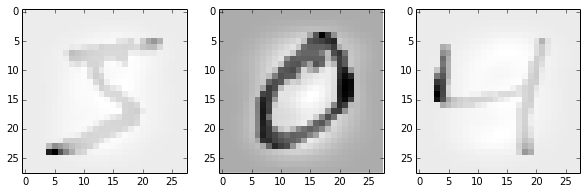

In [5]:
fig = plt.figure(figsize=(10,30))
for i in range(3):
    a=fig.add_subplot(1,3,(i+1))
    plt.imshow(-X[i,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

Note that the backgound is not uniform. That is due to the batchnormalization.

# Our first simple network
Let's define a MLP. We start with the architecture. All we do until the compling is using symbolic functions.

#### Definition of the network (architecture)

* An Input Layer with the following 4-dimensions: 
    * 0: Batch Size yet unkown hence `None`
    * 1: one "color" channel
    * 2,3: (28,28) pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units



In [6]:
input_var = T.tensor4('inputs') #This is a variable needed 
# 1st Layer
l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var) #None depend on batch size
# 2nd Layer
l_hid1 = lasagne.layers.DenseLayer(l_in, num_units=500, nonlinearity=lasagne.nonlinearities.sigmoid)
# 3rd Layer
l_hid2 = lasagne.layers.DenseLayer(l_hid1, num_units=50, nonlinearity=lasagne.nonlinearities.sigmoid)
# Last Layer
network = lasagne.layers.DenseLayer(l_hid2, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

/Library/Python/2.7/site-packages/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


#### Loss Function
To optimize the network we use the log-loss of the last layer. The log loss in lasagne is called 'lasagne.objectives.categorical_crossentropy'. 

In [7]:
target_var = T.ivector('targets') #The classes 0..9
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

/Library/Python/2.7/site-packages/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


#### Controlling the learning
Create update expressions for training, i.e., how to modify the parameters at each training step. Here, we'll use Stochastic Gradient Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.

In [8]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

#### Compiling the function for training
We know have everything in place to compile a function describing the training.

In [9]:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

#### Compling a function for testing

In [10]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var), dtype=theano.config.floatX)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

### Training the model
After the definition of the network the network has to be trained. We use the first 2400 samples for training and the 600 images from 2400-3000 for validation.  

In [11]:
X_train = X[0:2400,:,:,:]
X_val   = X[2400:3000,:,:,:]
y_train = y[0:2400]
y_val = y[2400:3000]

In [12]:
############################## Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [13]:
import pandas as pd
perf = pd.DataFrame(columns=['train_loss','valid_loss','valid_accuracy'])

In [14]:
# We iterate over epochs:
num_epochs = 100
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 50, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
    
    perf.loc[epoch] = [train_err / train_batches, val_err / train_batches, val_acc / val_batches]
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / train_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 100 took 0.163s
  training loss:		2.285374
  validation loss:		1.091113
  validation accuracy:		21.00 %
Epoch 2 of 100 took 0.152s
  training loss:		2.100532
  validation loss:		0.996479
  validation accuracy:		62.83 %
Epoch 3 of 100 took 0.147s
  training loss:		1.909607
  validation loss:		0.894727
  validation accuracy:		69.67 %
Epoch 4 of 100 took 0.144s
  training loss:		1.702203
  validation loss:		0.787833
  validation accuracy:		73.33 %
Epoch 5 of 100 took 0.144s
  training loss:		1.495270
  validation loss:		0.688070
  validation accuracy:		73.67 %
Epoch 6 of 100 took 0.142s
  training loss:		1.304386
  validation loss:		0.601403
  validation accuracy:		76.50 %
Epoch 7 of 100 took 0.144s
  training loss:		1.140071
  validation loss:		0.527516
  validation accuracy:		78.17 %
Epoch 8 of 100 took 0.139s
  training loss:		1.003855
  validation loss:		0.469065
  validation accuracy:		81.83 %
Epoch 9 of 100 took 0.142s
  training loss:		0.893384
  validation loss:		0.4225

####Training of the net. 

After the definition of the network the network has to be trained. Therefore the data is split automatically into 80% training set and 20% test set (controlled by `eval_size=0.2`). We use the first 3000 samples as the training set.  

### Fitting procedure / log loss
The log-loss $J(\theta)$ is calculated for the training-set and validation set. It is defined as follows:
<img src="imgs/logloss.png" width="700"/>



It is plotted for each epoch below. An  epoch is defined by touching each member of the training set once.

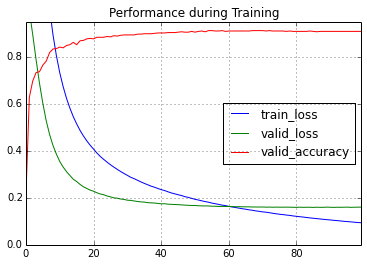

In [17]:
%matplotlib inline
perf[['train_loss','valid_loss','valid_accuracy']].plot(title='Performance during Training', ylim=(0,0.95))

## Task 1 (evaluate the learning phase)
* What is the value of the log-loss for perfect classification?
* [optional] What is the value for the log-loss for random assignment to the classes?
* Describe the form of the curve

## Task 1 (LSG)
* 0 since log(1)=0
* For random assinment the probability for each class ist 1/10. So ln(1/10) = -2.3. Hence J = 2.3
* The training loss reaches the optimal value of 0 but the validation loss on the untouched validation set goes to goes up a again. This indicates overfitting to the training set.

## Task 2 (evaluate on testset)
Now that we have fixed the weights of the network, we can make predictions on unseen data 3000-4000 and evaluate the performance. We first have to compile a function using the input and output variables.

In [39]:
pred = theano.function([input_var],[test_prediction])
res = pred(X[3000:4000])[0]
np.mean(np.argmax(res, axis=1) == y[3000:4000])

0.91700000000000004

In the notebook [MinimalLasagneCNN.ipynb](MinimalLasagneCNN.ipynb) we show how to use a CNN.